In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
pip install tensorflow==2.2

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras==2.3.1

Note: you may need to restart the kernel to use updated packages.


#Extract Data

In [3]:
import pickle
import numpy as np
import os

In [4]:
 def preprocess(raw_corpus):
  # raw_corpus = ''
  # with open(file) as f:
  #   raw_corpus = raw_corpus + '\n' + f.read()
  corpus = raw_corpus.split('\n')
  print('CORPUS SIZE', len(corpus), '\n')
  X = []
  Y = []
  words = []
  tags = []
  with_slash = False
  n_omitted = 0
  max_len = 0

  for line in corpus:
    if(len(line)>0):
        tempX = []
        tempY = []
        for word in line.split():
            try:            
                w, tag = word.split('/')
            except:
                # with_slash = True
                n_omitted = n_omitted + 1
                break

            w = w.lower()
            words.append(w)
            tags.append(tag)
            
            tempX.append(w)
            tempY.append(tag)
            max_len = max(max_len,len(tempX))
            # print(len(tempX))
        
        X.append(tempX)
        Y.append(tempY)
  return X,Y,words,tags,n_omitted,max_len

In [5]:
ls

BILSTM_TRY2/               PO_TAGGING.ipynb
BiLSTM_CRF_Final(1).ipynb  PickledData/
BiLSTM_CRF_try.ipynb       test_data/
NLTK_POS TAGGING.ipynb     train_data/
POS_TAGGING.ipynb


In [ ]:
file='ata/train_data.txt'
raw_corpus = ''
with open(file) as f:
  raw_corpus = raw_corpus + '\n' + f.read()
file2='/content/drive/MyDrive/BiLSTM_PosTag/Data/test_tagged.txt'
with open(file2) as f:
  raw_corpus = raw_corpus + '\n' + f.read()
X_train,Y_train,words,tags,n_omitted,max_len=preprocess(raw_corpus)

CORPUS SIZE 16650 



In [ ]:
print('OMITTED sentences: ', n_omitted, '\n')
print('TOTAL NO OF SAMPLES: ', len(X_train), '\n')
print('Max Length',max_len,'\n')
print('No of Words',len(words),'\n')

OMITTED sentences:  3 

TOTAL NO OF SAMPLES:  16647 

Max Length 116 

No of Words 351647 



In [ ]:
print('sample X_train: ', X_train[42], '\n')
print('sample Y_train: ', Y_train[42], '\n')

sample X_train:  ['ठहरने', 'के', 'लिए', '-', 'मध्यप्रदेश', 'पर्यटन', 'विकास', 'निगम', 'के', 'होटल', 'तथा', 'निजी', 'होटल', 'हैं', '।'] 

sample Y_train:  ['VM', 'PSP', 'PSP', 'SYM', 'NNP', 'NNP', 'NNP', 'NNP', 'PSP', 'NN', 'CC', 'JJ', 'NN', 'VM', 'SYM'] 



In [ ]:
def pickling(words,tags,X,Y,fname):
  words = set(words)
  tags = set(tags)

  print('VOCAB SIZE: ', len(words))
  print('TOTAL TAGS: ', len(tags))

  print('MAX_LEN: ', max_len)
  assert len(X) == len(Y)
  word2int = {}
  int2word = {}
  word2int['-PAD-'] = 0  # The special value used for padding
  word2int['-OOV-'] = 1  # The special value used for OOVs
  int2word[0]='-PAD-'
  int2word[1]='-00V-'
  i=2
  for _, word in enumerate(words):
      word2int[word] = i+1
      int2word[i+1] = word
      i+=1

  tag2int = {}
  int2tag = {}
  tag2int['-PAD-'] = 0
  int2tag[0]='-PAD-'
  for i, tag in enumerate(tags):
      tag2int[tag] = i+1
      int2tag[i+1] = tag
  X_numberised = []
  Y_numberised = []

  for sentence in X:
    tempX = []
    for word in sentence:
      tempX.append(word2int[word])
    X_numberised.append(tempX)
  for tags in Y:
    tempY = []
    for tag in tags:
        tempY.append(tag2int[tag])
    Y_numberised.append(tempY)
  X_numberised = np.asarray(X_numberised)
  Y_numberised = np.asarray(Y_numberised)

  pickle_files = [X_numberised, Y_numberised, word2int, int2word, tag2int, int2tag]

  if not os.path.exists('/content/drive/MyDrive/BiLSTM_PosTag/PickledData/'):
      print('MAKING DIRECTORY PickledData/ to save pickled glove file')
      os.makedirs('/content/drive/MyDrive/BiLSTM_PosTag/PickledData/')

  with open(fname, 'wb') as f:
      pickle.dump(pickle_files, f)

  print('Saved as pickle file')

In [ ]:
fname1='/content/drive/MyDrive/BiLSTM_PosTag/PickledData/data.pkl'
pickling(words,tags,X_train,Y_train,fname1)

VOCAB SIZE:  19229
TOTAL TAGS:  27
MAX_LEN:  116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Saved as pickle file


#Training

In [ ]:
# !pip install crf

In [ ]:
import numpy as np
import pickle, sys, os
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, Bidirectional, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-hecd37zb
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-hecd37zb
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=c8dfd25f1b1a8e189c6ecd6a6d0a57c3854cd42b30e884ef0befc6664c7b1590
  Stored in directory: /tmp/pip-ephem-wheel-cache-d1xatya2/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [ ]:
pip install keras-crf

     |████████████████████████████████| 1.1 MB 9.6 MB/s 
     |████████████████████████████████| 462 kB 53.0 MB/s 


In [ ]:
import tensorflow as tf
from keras import backend as K
from keras.engine.base_layer import Layer, InputSpec

try:
    from tensorflow.contrib.crf import crf_decode
except ImportError:
    from tensorflow.python.framework import dtypes
    from tensorflow.python.ops import array_ops, gen_array_ops, math_ops, rnn, rnn_cell


    class CrfDecodeForwardRnnCell(rnn_cell.RNNCell):
        """Computes the forward decoding in a linear-chain CRF.
        """

        def __init__(self, transition_params):
            """Initialize the CrfDecodeForwardRnnCell.
            Args:
              transition_params: A [num_tags, num_tags] matrix of binary
                potentials. This matrix is expanded into a
                [1, num_tags, num_tags] in preparation for the broadcast
                summation occurring within the cell.
            """
            self._transition_params = array_ops.expand_dims(transition_params, 0)
            self._num_tags = transition_params.get_shape()[0].value

        @property
        def state_size(self):
            return self._num_tags

        @property
        def output_size(self):
            return self._num_tags

        def __call__(self, inputs, state, scope=None):
            """Build the CrfDecodeForwardRnnCell.
            Args:
              inputs: A [batch_size, num_tags] matrix of unary potentials.
              state: A [batch_size, num_tags] matrix containing the previous step's
                    score values.
              scope: Unused variable scope of this cell.
            Returns:
              backpointers: [batch_size, num_tags], containing backpointers.
              new_state: [batch_size, num_tags], containing new score values.
            """
            # For simplicity, in shape comments, denote:
            # 'batch_size' by 'B', 'max_seq_len' by 'T' , 'num_tags' by 'O' (output).
            state = array_ops.expand_dims(state, 2)  # [B, O, 1]

            # This addition op broadcasts self._transitions_params along the zeroth
            # dimension and state along the second dimension.
            # [B, O, 1] + [1, O, O] -> [B, O, O]
            transition_scores = state + self._transition_params  # [B, O, O]
            new_state = inputs + math_ops.reduce_max(transition_scores, [1])  # [B, O]
            backpointers = math_ops.argmax(transition_scores, 1)
            backpointers = math_ops.cast(backpointers, dtype=dtypes.int32)  # [B, O]
            return backpointers, new_state


    class CrfDecodeBackwardRnnCell(rnn_cell.RNNCell):
        """Computes backward decoding in a linear-chain CRF.
        """

        def __init__(self, num_tags):
            """Initialize the CrfDecodeBackwardRnnCell.
            Args:
              num_tags
            """
            self._num_tags = num_tags

        @property
        def state_size(self):
            return 1

        @property
        def output_size(self):
            return 1

        def __call__(self, inputs, state, scope=None):
            """Build the CrfDecodeBackwardRnnCell.
            Args:
              inputs: [batch_size, num_tags], backpointer of next step (in time order).
              state: [batch_size, 1], next position's tag index.
              scope: Unused variable scope of this cell.
            Returns:
              new_tags, new_tags: A pair of [batch_size, num_tags]
                tensors containing the new tag indices.
            """
            state = array_ops.squeeze(state, axis=[1])  # [B]
            batch_size = array_ops.shape(inputs)[0]
            b_indices = math_ops.range(batch_size)  # [B]
            indices = array_ops.stack([b_indices, state], axis=1)  # [B, 2]
            new_tags = array_ops.expand_dims(
                gen_array_ops.gather_nd(inputs, indices),  # [B]
                axis=-1)  # [B, 1]

            return new_tags, new_tags


    def crf_decode(potentials, transition_params, sequence_length):
        """Decode the highest scoring sequence of tags in TensorFlow.
        This is a function for tensor.
        Args:
        potentials: A [batch_size, max_seq_len, num_tags] tensor, matrix of
                  unary potentials.
        transition_params: A [num_tags, num_tags] tensor, matrix of
                  binary potentials.
        sequence_length: A [batch_size] tensor, containing sequence lengths.
        Returns:
        decode_tags: A [batch_size, max_seq_len] tensor, with dtype tf.int32.
                    Contains the highest scoring tag indicies.
        best_score: A [batch_size] tensor, containing the score of decode_tags.
        """
        # For simplicity, in shape comments, denote:
        # 'batch_size' by 'B', 'max_seq_len' by 'T' , 'num_tags' by 'O' (output).
        num_tags = potentials.get_shape()[2].value

        # Computes forward decoding. Get last score and backpointers.
        crf_fwd_cell = CrfDecodeForwardRnnCell(transition_params)
        initial_state = array_ops.slice(potentials, [0, 0, 0], [-1, 1, -1])
        initial_state = array_ops.squeeze(initial_state, axis=[1])  # [B, O]
        inputs = array_ops.slice(potentials, [0, 1, 0], [-1, -1, -1])  # [B, T-1, O]
        backpointers, last_score = rnn.dynamic_rnn(
            crf_fwd_cell,
            inputs=inputs,
            sequence_length=sequence_length - 1,
            initial_state=initial_state,
            time_major=False,
            dtype=dtypes.int32)  # [B, T - 1, O], [B, O]
        backpointers = gen_array_ops.reverse_sequence(backpointers, sequence_length - 1, seq_dim=1)  # [B, T-1, O]

        # Computes backward decoding. Extract tag indices from backpointers.
        crf_bwd_cell = CrfDecodeBackwardRnnCell(num_tags)
        initial_state = math_ops.cast(math_ops.argmax(last_score, axis=1), dtype=dtypes.int32)  # [B]
        initial_state = array_ops.expand_dims(initial_state, axis=-1)  # [B, 1]
        decode_tags, _ = rnn.dynamic_rnn(
            crf_bwd_cell,
            inputs=backpointers,
            sequence_length=sequence_length - 1,
            initial_state=initial_state,
            time_major=False,
            dtype=dtypes.int32)  # [B, T - 1, 1]
        decode_tags = array_ops.squeeze(decode_tags, axis=[2])  # [B, T - 1]
        decode_tags = array_ops.concat([initial_state, decode_tags], axis=1)  # [B, T]
        decode_tags = gen_array_ops.reverse_sequence(decode_tags, sequence_length, seq_dim=1)  # [B, T]

        best_score = math_ops.reduce_max(last_score, axis=1)  # [B]
        return decode_tags, best_score


class CRFLayer(Layer):

    def __init__(self, transition_params=None, **kwargs):
        super(CRFLayer, self).__init__(**kwargs)
        self.transition_params = transition_params
        self.input_spec = [InputSpec(ndim=3), InputSpec(ndim=2)]
        self.supports_masking = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape[0]) == 3

        return input_shape[0]

    def build(self, input_shape):
        """Creates the layer weights.

        Args:
            input_shape (list(tuple, tuple)): [(batch_size, n_steps, n_classes), (batch_size, 1)]
        """
        assert len(input_shape) == 2
        assert len(input_shape[0]) == 3
        assert len(input_shape[1]) == 2
        n_steps = input_shape[0][1]
        n_classes = input_shape[0][2]
        assert n_steps is None or n_steps >= 2

        self.transition_params = self.add_weight(shape=(n_classes, n_classes),
                                                 initializer='uniform',
                                                 name='transition')
        self.input_spec = [InputSpec(dtype=K.floatx(), shape=(None, n_steps, n_classes)),
                           InputSpec(dtype='int32', shape=(None, 1))]
        self.built = True

    def viterbi_decode(self, potentials, sequence_length):
        """Decode the highest scoring sequence of tags in TensorFlow.

        This is a function for tensor.

        Args:
            potentials: A [batch_size, max_seq_len, num_tags] tensor, matrix of unary potentials.
            sequence_length: A [batch_size] tensor, containing sequence lengths.

        Returns:
            decode_tags: A [batch_size, max_seq_len] tensor, with dtype tf.int32.
                         Contains the highest scoring tag indicies.
        """
        decode_tags, best_score = crf_decode(potentials, self.transition_params, sequence_length)

        return decode_tags

    def call(self, inputs, mask=None, **kwargs):
        inputs, sequence_lengths = inputs
        self.sequence_lengths = K.flatten(sequence_lengths)
        y_pred = self.viterbi_decode(inputs, self.sequence_lengths)
        nb_classes = self.input_spec[0].shape[2]
        y_pred_one_hot = K.one_hot(y_pred, nb_classes)

        return K.in_train_phase(inputs, y_pred_one_hot)

    def loss(self, y_true, y_pred):
        """Computes the log-likelihood of tag sequences in a CRF.

        Args:
            y_true : A (batch_size, n_steps, n_classes) tensor.
            y_pred : A (batch_size, n_steps, n_classes) tensor.

        Returns:
            loss: A scalar containing the log-likelihood of the given sequence of tag indices.
        """
        y_true = K.cast(K.argmax(y_true, axis=-1), dtype='int32')
        log_likelihood, self.transition_params = tf.contrib.crf.crf_log_likelihood(
            y_pred, y_true, self.sequence_lengths, self.transition_params)
        loss = tf.reduce_mean(-log_likelihood)

        return loss

    def get_config(self):
        config = {
            'transition_params': K.eval(self.transition_params),
        }
        base_config = super(CRFLayer, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))


def create_custom_objects():
    """Returns the custom objects, needed for loading a persisted model."""
    instanceHolder = {'instance': None}

    class ClassWrapper(CRFLayer):
        def __init__(self, *args, **kwargs):
            instanceHolder['instance'] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)

    def loss(*args):
        method = getattr(instanceHolder['instance'], 'loss')
        return method(*args)

    return {'CRFLayer': ClassWrapper, 'loss': loss}


In [ ]:
# from crf import CRFLayer, create_custom_objects
from keras_contrib.layers import CRF
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras import backend as K
from keras_contrib.layers import CRF
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd

In [ ]:
# PARAMETERS ================
MAX_SEQUENCE_LENGTH = max_len #Calculated for this dataset
EMBEDDING_DIM = 300 #Fasttext hindi embeddigns
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
MODEL_TYPE = 2
#MODEL TYPE 1 = Bi-Lstm
#MODEL TYPE 2 = Bi-Lstm + CRF
dropout = 0.5
epochs = 100

In [ ]:
with open('/content/drive/MyDrive/BiLSTM_PosTag/PickledData/data.pkl', 'rb') as f:
    X, y, word2int, int2word, tag2int, int2tag = pickle.load(f)

In [ ]:
def generator(all_X, all_y, n_classes, batch_size=BATCH_SIZE):
    num_samples = len(all_X)

    while True:

        for offset in range(0, num_samples, batch_size):
            
            X = all_X[offset:offset+batch_size]
            #S = np.asarray([MAX_SEQUENCE_LENGTH] * batch_size, dtype='int32')
            y = all_y[offset:offset+batch_size]

            y = to_categorical(y, num_classes=n_classes)


            yield shuffle(X, y)

def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

In [ ]:
n_tags = len(tag2int)

X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = pad_sequences(y, maxlen=MAX_SEQUENCE_LENGTH)

print('TOTAL TAGS', len(tag2int))
print('TOTAL WORDS', len(word2int))


TOTAL TAGS 28
TOTAL WORDS 19231


In [ ]:
# shuffle the data
# X, y = shuffle(X, y)

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT,random_state=42)

# split training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VALIDATION_SPLIT, random_state=42)


In [ ]:
X_test_copy=X_test.copy()
y_test_copy = y_test.copy()

In [ ]:
n_train_samples = X_train.shape[0]
n_val_samples = X_val.shape[0]
n_test_samples = X_test.shape[0]

print('We have %d TRAINING samples' % n_train_samples)
print('We have %d VALIDATION samples' % n_val_samples)
print('We have %d TEST samples' % n_test_samples)


We have 10653 TRAINING samples
We have 2664 VALIDATION samples
We have 3330 TEST samples


In [ ]:
# make generators for training and validation
train_generator = generator(all_X=X_train, all_y=y_train, n_classes=n_tags + 1)
validation_generator = generator(all_X=X_val, all_y=y_val, n_classes=n_tags + 1)


In [ ]:
with open('/content/drive/MyDrive/BiLSTM_PosTag/PickledData/Glove.pkl', 'rb') as f:
	embeddings_index = pickle.load(f)

In [ ]:
print('Total %s word vectors.' % len(embeddings_index))

# + 1 to include the unkown word
embedding_matrix = np.random.random((len(word2int) + 1, EMBEDDING_DIM))

Total 30395 word vectors.


In [ ]:
for word, i in word2int.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embeddings_index will remain unchanged and thus will be random.
        embedding_matrix[i] = embedding_vector

In [ ]:

print('Embedding matrix shape', embedding_matrix.shape)
print('X_train shape', X_train.shape)


Embedding matrix shape (19232, 300)
X_train shape (10653, 116)


In [ ]:
embedding_layer = Embedding(len(word2int) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

In [ ]:
# # Bi-Lstm 
# if(MODEL_TYPE == 1):
#   l_lstm = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.1))(embedded_sequences)
#   preds = TimeDistributed(Dense(n_tags + 1, activation='softmax'))(l_lstm)
#   model = Model(sequence_input, preds)
#   model.compile(loss='categorical_crossentropy',
#                 optimizer=Adam(0.001),
#                 metrics=['accuracy', ignore_class_accuracy(0)])
#   print("model fitting - Bidirectional LSTM")

In [ ]:
# Bi-Lstm + CRF
if(MODEL_TYPE == 2):
  l_lstm = Bidirectional(LSTM(512, return_sequences=True, recurrent_dropout=0.5))(embedded_sequences)
  model = TimeDistributed(Dense(50, activation='relu'))(l_lstm)
  crf = CRF(n_tags+1)  # CRF layer
  preds = crf(model)  # output
  model = Model(sequence_input, preds)

  model.compile(loss=crf.loss_function,
                optimizer=Adam(0.001),
                metrics=[crf.accuracy,tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
  print("model fitting - Bidirectional LSTM +CRF")

/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


model fitting - Bidirectional LSTM +CRF


In [ ]:
model.summary()
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 116)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 116, 300)          5769600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 116, 1024)         3330048   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 116, 50)           51250     
_________________________________________________________________
crf_1 (CRF)                  (None, 116, 29)           2378      
Total params: 9,153,276
Trainable params: 9,153,276
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit_generator(train_generator, 
                     steps_per_epoch=n_train_samples//BATCH_SIZE,
                     validation_data=validation_generator,
                     validation_steps=n_val_samples//BATCH_SIZE,
                     epochs=epochs,
                     callbacks=callbacks,
                     verbose=1)

Epoch 1/100
332/332 [==============================] - 280s 844ms/step - loss: 0.1639 - crf_viterbi_accuracy: 0.9528 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0340 - val_crf_viterbi_accuracy: 0.9886 - val_precision: 0.9884 - val_recall: 0.1074
Epoch 2/100


/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


332/332 [==============================] - 280s 843ms/step - loss: 0.0235 - crf_viterbi_accuracy: 0.9914 - precision: 0.9886 - recall: 0.1452 - val_loss: 0.0089 - val_crf_viterbi_accuracy: 0.9921 - val_precision: 0.9897 - val_recall: 0.1553
Epoch 3/100
332/332 [==============================] - 281s 846ms/step - loss: 0.0097 - crf_viterbi_accuracy: 0.9946 - precision: 0.9903 - recall: 0.1659 - val_loss: 0.0131 - val_crf_viterbi_accuracy: 0.9930 - val_precision: 0.9908 - val_recall: 0.1699
Epoch 4/100
332/332 [==============================] - 278s 837ms/step - loss: 0.0018 - crf_viterbi_accuracy: 0.9960 - precision: 0.9912 - recall: 0.1748 - val_loss: 6.8872e-04 - val_crf_viterbi_accuracy: 0.9936 - val_precision: 0.9915 - val_recall: 0.1770
Epoch 5/100
332/332 [==============================] - 276s 831ms/step - loss: -0.0037 - crf_viterbi_accuracy: 0.9968 - precision: 0.9918 - recall: 0.1798 - val_loss: -0.0010 - val_crf_viterbi_accuracy: 0.9937 - val_precision: 0.9920 - val_recall: 0

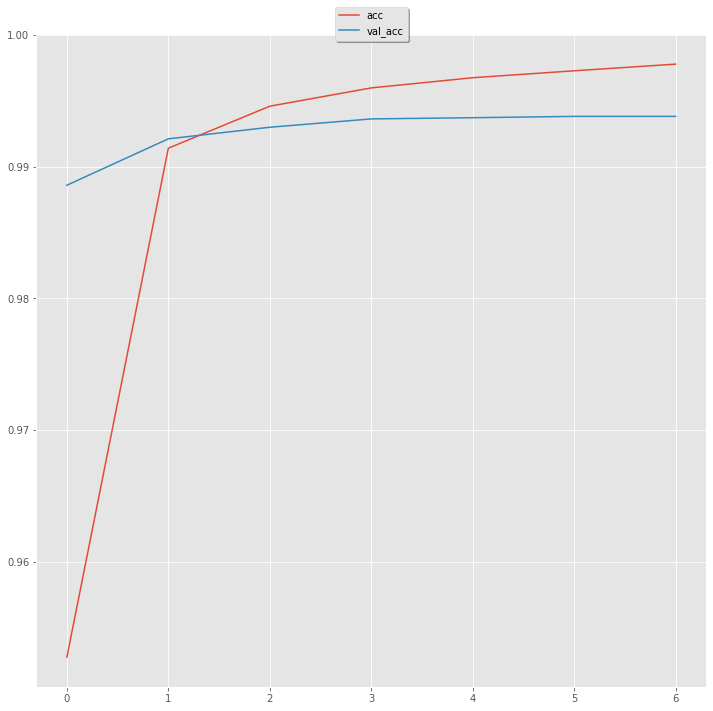

In [ ]:
hist = pd.DataFrame(history.history)
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"], label="acc")
plt.plot(hist["val_crf_viterbi_accuracy"], label="val_acc")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
 fancybox=True, shadow=True)
plt.savefig('Bi-Lstm+CRF')
plt.show()

In [ ]:
if not os.path.exists('/content/drive/MyDrive/BiLSTM_PosTag/Models/'):
    print('MAKING DIRECTORY Models/ to save model file')
    os.makedirs('/content/drive/MyDrive/BiLSTM_PosTag/Models/')

In [ ]:
y_test = to_categorical(y_test, num_classes=n_tags+1)
test_results = model.evaluate(X_test, y_test, verbose=1)
print('TEST LOSS %f \nTEST ACCURACY: %f' % (test_results[0], test_results[1]))

3330/3330 [==============================] - 19s 6ms/step
TEST LOSS 0.000789 
TEST ACCURACY: 0.993778


# Testing

In [ ]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
        token_sequences.append(token_sequence)
 
    return token_sequences

In [ ]:
predictions = model.predict(X_test,verbose=1)

3330/3330 [==============================] - 23s 7ms/step


In [ ]:
len(predictions)

3330

In [ ]:
Y_PRED=logits_to_tokens(predictions, {i: t for t, i in tag2int.items()})

# Saving in CSV

In [ ]:
import csv

In [ ]:
fields=['word','correct_tag','predicted_tag']

In [ ]:
li=open("/content/drive/MyDrive/BiLSTM_PosTag/Output/output.csv",'w')

In [ ]:
writer=csv.writer(li)

In [ ]:
writer.writerow(fields)

32

In [ ]:
print(len(X_test[0]), len(Y_PRED[0]),len(y_test_copy[0]))

116 116 116


In [ ]:
for i in range(len(X_test)):
  for j in range(len(X_test[i])):
    if(int2word[X_test[i][j]]!='-PAD-'):
      writer.writerow([int2word[X_test[i][j]],int2tag[y_test_copy[i][j]],Y_PRED[i][j]])

In [ ]:
li.close()

In [ ]:
out_data=pd.read_csv('/content/drive/MyDrive/BiLSTM_PosTag/Output/output.csv')

In [ ]:
count=0
for i in range(len(out_data)):
    if out_data['correct_tag'][i]==out_data['predicted_tag'][i]:
        count+=1;

In [ ]:
print('Accuracy=',(count/len(out_data))*100)

Accuracy= 96.60201750776784


In [ ]:
print('.................Wrong Outputs................')
for i in range(len(out_data)):
    if out_data['correct_tag'][i]!=out_data['predicted_tag'][i]:
        print(out_data['word'][i],out_data['correct_tag'][i],out_data['predicted_tag'][i])

.................Wrong Outputs................
अना NNP QC
ग्रोनेफेल्ड NNP NN
भिड़ना VM NN
था VAUX VM
यह DEM PRP
२९,००० QC NNP
ये DEM PRP
चार QC NNP
सिंह NN NNP
जैसे PRP PSP
मैन NN NNP
ऑफ NN NNP
द NN NNP
मेहराबनुमा JJ NN
निकलीं VM NN
प्रस्ताव NNP NN
१२६७ NNP NN
दक्षिणा NNP NN
माँ NNP NN
कौन NNP WQ
बनेगा NNP VM
लिहाजा CC RB
अतिरिक्त NN JJ
तो CC PRP
पुरस्कार NN NNP
आयोग NN NNP
दो NNP QC
अलगाववादी NN JJ
भाग NN VM
लिया VM VAUX
जहां PRP RB
तहां RDP NNP
बजट NNP NN
ग़ैर NN JJ
अधिक QF NN
की PSP VM
स्थानीय JJ NNP
सतर्कता NN NNP
शाखा NN NNP
ट्रांसपोर्ट NNP NN
सिस्टम NNP NN
और NNP CC
कमांड NN NNP
एवं NNP CC
तसुदेना NNP NN
बड़ी RDP JJ
कोर्ट NN NNP
विंग NNP NN
पॉपुलर JJ NN
रक्षा NNP NN
सामग्री NNP NN
नो NN NNP
डिलीवरी NN JJ
उपग्रह NNP NN
संचार NNP NN
आंतकवादियों NN NNP
लोकल NN JJ
शंघाई NNP NN
और QF CC
ऑपरेशनल JJ NN
फिल्म NN NNP
यह DEM PRP
युवा NN JJ
नौ NNP QC
लगी VAUX VM
तक RP PSP
अलग JJ RB
जबरदस्ती NN RB
योजना NN NNP
आयोग NN NNP
समानताएं NN JJ
माँगें VM NN
माँगें VM NN
इत्तफाक NN VM
इस PRP DEM
फीका

In [ ]:
! pip install seqeval

     |████████████████████████████████| 43 kB 1.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=d7137b447203e61b4f4a361e2b03e3e30c513929a1560afab2437447d0ce17aa
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
test_labels=[out_data['correct_tag'].tolist()]

In [ ]:
pred_labels=[out_data['predicted_tag'].tolist()]

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PRP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: JJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: QC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PSP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NNP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning

F1-score: 95.7%


In [ ]:
li=open("/content/drive/MyDrive/BiLSTM_PosTag/Output/output2.csv",'w')

In [ ]:
writer=csv.writer(li)

In [ ]:
writer.writerow(fields)

32

In [ ]:
for i in range(len(X_test)):
  for j in range(len(X_test[i])):
      writer.writerow([int2word[X_test[i][j]],int2tag[y_test_copy[i][j]],Y_PRED[i][j]])

In [ ]:
li.close()

In [ ]:
out_data2=pd.read_csv('/content/drive/MyDrive/BiLSTM_PosTag/Output/output2.csv')

In [ ]:
count=0
for i in range(len(out_data2)):
    if out_data2['correct_tag'][i]==out_data2['predicted_tag'][i]:
        count+=1;

In [ ]:
print('Accuracy2=',(count/len(out_data2))*100)

Accuracy2= 99.37998343170757
